# きちんとlossが収束するようにしたい

In [1]:
from datetime import datetime
import pytz
import os
import numpy as np
import torch
import timm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from model2 import Net,run_check_net
from dataset import read_one_data, read_one_truth
from czii_helper import dotdict

/home2/y2023/m2311203/.conda/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#trainに使う画像を取得
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#マスクの大きさ
mask_size= {
    "defolt" : 1,
    "apo-ferritin" : 1,
    'beta-amylase' : 1, 
    'beta-galactosidase' : 1, 
    'ribosome' : 1, 
    'thyroglobulin' : 1, 
    'virus-like-particle' : 1,
}
MOLECULES = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

In [3]:
import cc3d
from dataset import *

def probability_to_location(probability,cfg):
    _,D,H,W = probability.shape

    location={}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(probability[l]>cfg.threshold[p.name], return_N=True)
        stats = cc3d.statistics(cc)
        zyx=stats['centroids'][1:]*10
        xyz = np.ascontiguousarray(zyx[:,::-1]) 
        location[p.name]=xyz
        '''
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        '''
    return location

def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz)>0:
            df = pd.DataFrame(data=xyz, columns=['x','y','z'])
            #df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column='particle_type', value=p.name)
            location_df.append(df)
    location_df = pd.concat(location_df)
    return location_df

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    #'/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
       "../analyze/model.pth",
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

In [4]:
from scipy.optimize import linear_sum_assignment

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score

def printCV(valid_id,cfg,net):
    net.output_type = ['infer']
    submit_df = []
    net.eval()
    volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
    D, H, W = volume.shape
    probability = np.zeros((7, D, H, W), dtype=np.float32)
    count = np.zeros((7, D, H, W), dtype=np.float32)
    pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)

    num_slice = 32
    zz = list(range(0, D - num_slice, num_slice // 2)) + [D - num_slice]

    for z in zz:
        print('\r', f'z:{z}', end='', flush=True)
        image = pad_volume[z:z + num_slice]
        batch = dotdict(
            image=torch.from_numpy(image).unsqueeze(0),
        )
        with torch.amp.autocast('cuda', enabled=True):
            with torch.no_grad():
                output = net(batch)
        prob = output['particle'][0].cpu().numpy()
        probability[:, z:z + num_slice] += prob[:, :, :H, :W]
        count[:, z:z + num_slice] += 1
    probability = probability / (count + 0.0001)
    location = probability_to_location(probability, cfg)
    df = location_to_df(location)
    df.insert(loc=0, column='experiment', value=id)
    submit_df.append(df)

    num_volume = len(valid_id)
    submit_df = pd.concat(submit_df)

    submit_df.insert(loc=0, column='id', value=np.arange(len(submit_df)))
    
    gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')

    print(gb)
    print('lb_score:', lb_score)

    net.train()
    net.output_type = ['infer', 'loss']

In [5]:
def generate_mask(dic,mask_size):
    mask = np.zeros((184, 630, 630), dtype=np.int64)
    ID =0
    for target in MOLECULES:
        ID += 1
        for i in range(len(dic[target])):
            radius = mask_size[target]
            y = dic[target][i][0]
            x = dic[target][i][1]
            z = dic[target][i][2]

            # スケーリングと整数変換
            x, y, z = x / 10, y / 10, z / 10
            # 球状にmaskを作成
            for dz in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    for dy in range(-radius, radius + 1):
                        # 球の条件を満たすか確認
                        if dx**2 + dy**2 + dz**2 <= radius**2:
                            nx, ny, nz = x + dx, y + dy, z + dz
                            # マスクの範囲内でのみ更新
                            if 0 <= nx < mask.shape[1] and 0 <= ny < mask.shape[2] and 0 <= nz < mask.shape[0]:
                                nz , nx, ny = int(nz), int(nx), int(ny)
                                mask[nz, nx, ny] = ID
    return mask

In [6]:
#3Dデータとターゲットの位置の辞書が取得できる
volume = read_one_data("TS_73_6",train_dir)
y = read_one_truth("TS_73_6",mask_dir)
mask = generate_mask(y,mask_size)
#630*630*184から640*640*184に変換
#z軸方向は変化なし
volume = np.pad(volume,((0,0),(5,5),(5,5)), 'constant')
mask = np.pad(mask,((0,0),(5,5),(5,5)), 'constant')

print(volume.shape)

(184, 640, 640)


In [7]:
volume[0:32].shape

(32, 640, 640)

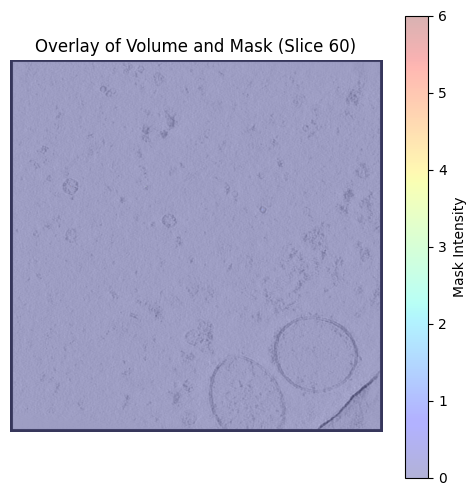

In [8]:
import matplotlib.pyplot as plt

# マスクとボリュームのスライスを取得
slice_index = 60  # 任意のスライスインデックス
mask_slice = mask[slice_index]
volume_slice = volume[slice_index]

# 重ねて表示
plt.figure(figsize=(6, 6))
plt.imshow(volume_slice, cmap='gray', alpha=0.7)  # 背景画像
plt.imshow(mask_slice, cmap='jet', alpha=0.3)    # 重ねるマスク（カラーマップを分ける）
plt.title(f"Overlay of Volume and Mask (Slice {slice_index})")
plt.axis('off')  # 軸を非表示
plt.colorbar(label="Mask Intensity")  # 色の強度を確認できるカラーバーを追加
plt.show()


In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, volume, mask, transform=None):
        self.volume = volume
        self.mask = mask
        self.transform = transform

    def __len__(self):
        return len(self.volume)

    def __getitem__(self, idx):
        volume = self.volume[idx:idx+32]
        mask = self.mask[idx:idx+32]

        volume = torch.from_numpy(volume)
        mask = torch.from_numpy(mask).long()

        if self.transform:
            volume = self.transform(volume)
            mask = self.transform(mask)

        return {'image': volume, 'mask': mask}

In [10]:
dataset = Dataset(volume, mask)
dataLoader = DataLoader(dataset, batch_size=2, shuffle=True)

# 学習の再現

In [11]:
valid_dir = '../input/czii-cryo-et-object-identification/train'
valid_id = ['TS_5_4', "TS_6_4","TS_6_6","TS_69_2","TS_73_6","TS_86_3"]
test_id = ["TS_99_9"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net = Net(pretrained=True,cfg=cfg)
net.output_type = ['infer','loss']
net = net.to(device)

cuda


In [12]:
# パラメータ設定
num_epochs = 40 # エポック数
learning_rate = 1e-3 * 0.5
model_save_path = 'model1.pth'  # 最終モデル保存ファイル

#net = torch.nn.DataParallel(net)

# Optimizer設定
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)
# 学習ループ
for epoch in range(num_epochs):

    #学習率の確認
    #print(f'epoch: {epoch+1}, lr: {scheduler.get_last_lr()}')
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for i, id in enumerate(valid_id):
        loss_s = []
        print(i, id, '---------------')
        volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
        mask = read_one_truth(id, overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')
        mask = generate_mask(mask, mask_size)

        D, H, W = volume.shape
        print(D, H, W)

        d, h, w = mask.shape
        if D != d or H != h or W != w:
            print('mask shape mismatch')
            break

        pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
        
        num_slice = 32
        zz = list(range(0, D - num_slice, num_slice // 2)) + [D - num_slice]
        for z in zz:
            print(f'\r z:{z}', end='', flush=True)
            image = pad_volume[z:z + num_slice]
            mask = pad_volume[z:z + num_slice]

            #batch = dotdict(
            #    image=torch.from_numpy(image).unsqueeze(0).to(device),
            #    mask=torch.from_numpy(mask).unsqueeze(0).long().to(device),
            #)

            batch = dotdict(
                image=torch.from_numpy(image).unsqueeze(0).to(device),
                mask=torch.from_numpy(mask).unsqueeze(0).long().to(device),
            )            
            
            with torch.amp.autocast('cuda', enabled=True):
                output = net(batch)
                loss = output['mask_loss']
            
          #  print('batch')
          #  for k, v in batch.items():
          #      if k == 'D':
          #          print(f'{k:>32} : {v} ')
          #      else:
          #          print(f'{k:>32} : {v.shape} ')

          #  print('output')
          #  for k, v in output.items():
          #      if 'loss' not in k:
          #          print(f'{k:>32} : {v.shape} ')
           # print('loss')
            for k, v in output.items():
                if 'loss' in k:
                    print(f'{k:>32} : {v.item()} ')    
            loss_s.append(loss.item())
                
            # 逆伝播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('')
        print('Avelage_loss:', np.mean(loss_s))
        #scheduler.step()
    printCV(test_id,cfg,net)

# 学習後にモデルを1回だけ保存
torch.save(net.state_dict(), model_save_path)
print(f"Final model saved to {model_save_path}")


Epoch 1/40
0 TS_5_4 ---------------
184 630 630
 z:0                       mask_loss : 2.4449269771575928 
 z:16                       mask_loss : 2.4398465156555176 
 z:32                       mask_loss : 2.433755397796631 
 z:48                       mask_loss : 2.4274299144744873 
 z:64                       mask_loss : 2.4216930866241455 
 z:80                       mask_loss : 2.416201591491699 
 z:96                       mask_loss : 2.410917282104492 
 z:112                       mask_loss : 2.4049675464630127 
 z:128                       mask_loss : 2.398036241531372 
 z:144                       mask_loss : 2.3909878730773926 
 z:152                       mask_loss : 2.384913444519043 

Avelage_loss: 2.4157887155359443
1 TS_6_4 ---------------
184 630 630
 z:0                       mask_loss : 2.371971368789673 
 z:16                       mask_loss : 2.3676400184631348 
 z:32                       mask_loss : 2.362276077270508 
 z:48                       mask_loss : 2.3562

# サブミットの再現

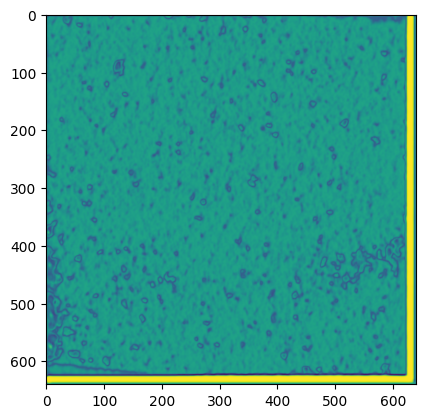

: 

In [17]:
#output['particle']を可視化
import matplotlib.pyplot as plt
import pandas as pd

#output['particle'][0][1][16]を可視化
particle = output['particle'][0][0][15].detach().cpu().numpy()
plt.imshow(particle)


In [14]:
valid_dir = '../input/czii-cryo-et-object-identification/train'
valid_id = ['TS_86_3', ]
cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    #'/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
       "../analyze/model.pth",
    threshold={ 
        'apo-ferritin': 0.005,
        'beta-amylase': 0.005,
        'beta-galactosidase': 0.005,
        'ribosome': 0.005,
        'thyroglobulin': 0.005,
        'virus-like-particle': 0.005,
    },
)

In [15]:
net = Net(pretrained=False, cfg=cfg)
#state_dict = torch.load(cfg.checkpoint, map_location=lambda storage, loc: storage)['state_dict']
# チェックポイントをロード
checkpoint = torch.load('model1.pth', map_location=lambda storage, loc: storage)

net.load_state_dict(checkpoint)


net.cuda()
net.eval()
net.output_type = ['infer']

submit_df = []
for i,id in enumerate(valid_id):
    print(i, id, '---------------')
    volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
    D, H, W = volume.shape
    print(D, H, W)

    probability = np.zeros((7, D, H, W), dtype=np.float32)
    count = np.zeros((7, D, H, W), dtype=np.float32)
    pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
    
    num_slice=32
    zz = list(range(0, D - num_slice, num_slice//2)) + [D - num_slice]

    print('zz:', zz)
    for z in zz:
        print('\r',f'z:{z}', end='',flush=True)
        image = pad_volume[z:z + num_slice]
        batch = dotdict(
            image=torch.from_numpy(image).unsqueeze(0),
        )
        with torch.amp.autocast('cuda', enabled=True):
            with torch.no_grad():
                output = net(batch)
        prob = output['particle'][0].cpu().numpy()
        probability[:, z:z + num_slice] += prob[:, :, :H, :W]
        count[:, z:z + num_slice] += 1
    probability = probability / (count + 0.0001)
    location = probability_to_location(probability, cfg)
    df = location_to_df(location)
    df.insert(loc=0, column='experiment', value=id)
    submit_df.append(df)
    print('')

print('\ndone!')
num_volume = len(valid_id)
print('')
submit_df = pd.concat(submit_df)
submit_df.insert(loc=0, column='id', value=np.arange(len(submit_df)))
submit_df.to_csv('submission.csv', index=False)

/tmp/ipykernel_2684726/2717756316.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model1.pth', map_location=lambda storage, loc: storage)


0 TS_86_3 ---------------
184 630 630
zz: [0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 152]
 z:152

done!



#　検証スコア

['TS_86_3']
 TS_86_3 beta-amylase

 TS_86_3 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  1  64    0    64   1        0.0     0.0      0.0   
1         beta-amylase  1   9    0     9   1        0.0     0.0      0.0   
2   beta-galactosidase  1  23    0    23   1        0.0     0.0      0.0   
3             ribosome  1  55    0    55   1        0.0     0.0      0.0   
4        thyroglobulin  2  45    0    45   2        0.0     0.0      0.0   
5  virus-like-particle  1  29    0    29   1        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_86_3 apo-ferritin
	 num truth   : 64
	 num predict : 1
	 num hit  : 0
	 num fp   : 1
	 num miss : 64
TS_86_3 beta-amylase
	 num truth   : 9
	 num predict : 1
	 num hit  : 0
	 num fp   : 1
	 num miss : 9
TS_86_3 beta-galactosidase
	 num truth   : 23
	 num predict : 1
	 num hit  : 0
	 num fp   : 1
	 num miss : 23
TS_86_3 ribosome
	 num 

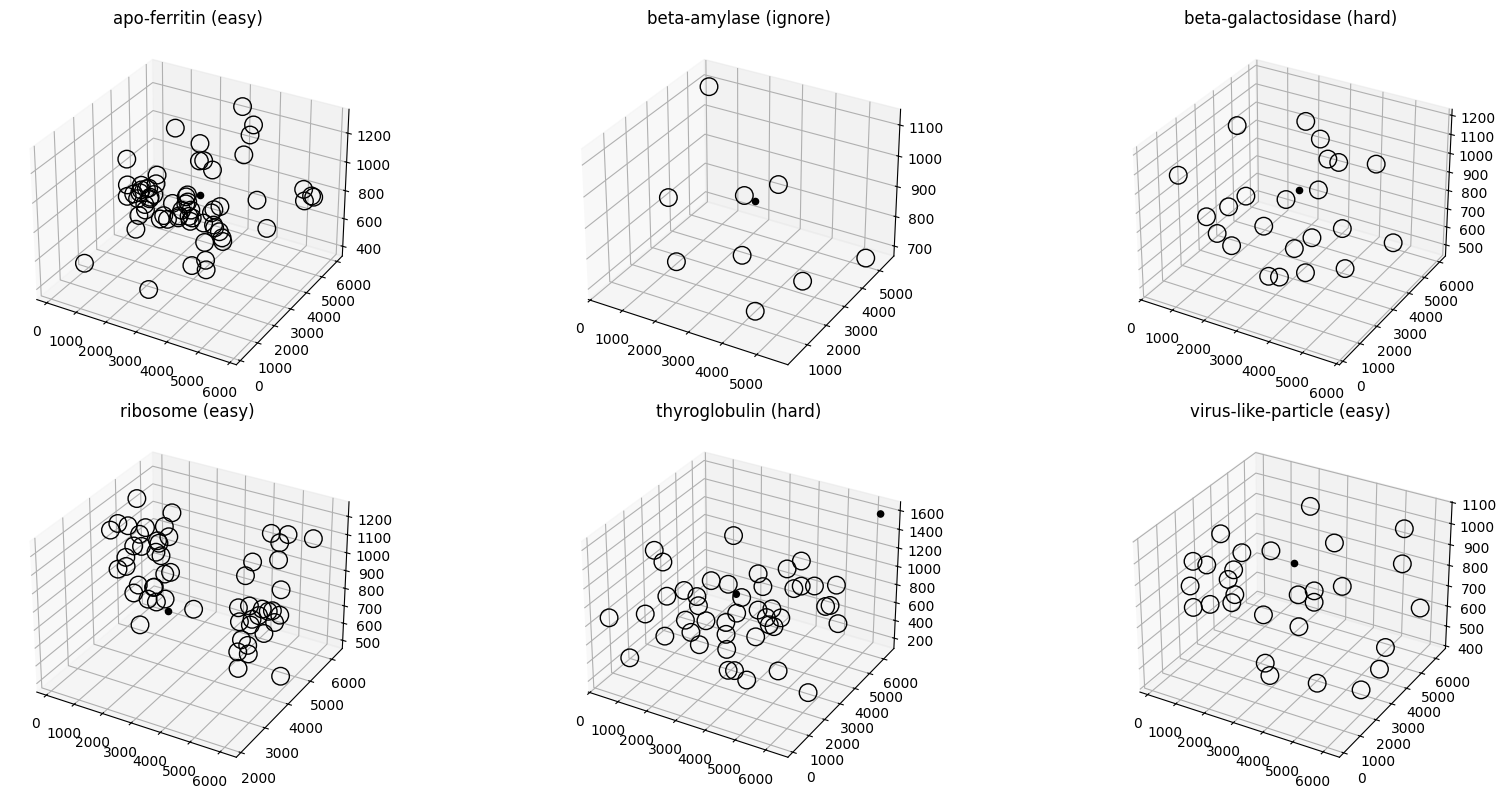

In [16]:

MODE = 'local'
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0